<a href="https://colab.research.google.com/github/freida20git/nanoparticle-classification/blob/main/cubes/dots_training_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3 types of detections

data1: cubes, pyramids,

data2: triangles, circle, truncated

data3: dots, other


# create directories:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir dots_data

In [ ]:
!cp -r '/content/drive/MyDrive/dots_data_new/test' /content/dots_data
!cp -r '/content/drive/MyDrive/dots_data_new/train' /content/dots_data
!cp -r '/content/drive/MyDrive/dots_data_new/validation' /content/dots_data

In [ ]:
import os
import shutil

# Assuming CLASS_MAP is defined elsewhere
CLASS_MAP = {
    "dot": 0,
    "other": 1,
}

def copy_and_prefix_images(src_base_dir, dst_flat_dir):
    """
    Copies image files from a structured directory (train/validation/test/class),
    replaces the initial part of the filename with class_split, and saves them
    in a single flat destination directory. Original files are untouched.
    """
    os.makedirs(dst_flat_dir, exist_ok=True)

    for split_folder in ['train', 'validation', 'test']:
        # Determine the split name (train, valid, test)
        split_name = 'valid' if split_folder == 'valid' else split_folder
        for cls in CLASS_MAP.keys():
            src_folder = os.path.join(src_base_dir, split_folder, cls)
            if os.path.exists(src_folder):
                for filename in os.listdir(src_folder):
                    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                        # Split the filename into parts
                        name, ext = os.path.splitext(filename)
                        parts = name.split('_')
                        if len(parts) != 6:
                            print(f"Skipping invalid filename format: {filename}")
                            continue
                        # Combine the new prefix with the parts to keep
                        new_name_parts = [cls, parts]

                        # Join the new parts to form the new filename base
                        new_name_base = f'{cls}_{name}'

                        # Construct the final new filename with extension
                        new_filename = new_name_base + ext

                        src_path = os.path.join(src_folder, filename)
                        dst_path = os.path.join(dst_flat_dir, new_filename)

                        shutil.copy2(src_path, dst_path)  # Copy without modifying original

# Example usage
src_directory = '/content/dots_data'
dst_directory = '/content/prefixed_flat_images'

copy_and_prefix_images(src_directory, dst_directory)
print(f"All images copied with class prefix to: {dst_directory}")

All images copied with class prefix to: /content/prefixed_flat_images


In [ ]:
!cp -r '/content/drive/MyDrive/dots' /content

In [ ]:
from PIL import Image
import os
def find_image_sizes(base_dir):
    image_dict={}
    try:
      for i in os.listdir(base_dir):
          for j in os.listdir(os.path.join(base_dir,i)):
            image_path=os.path.join(base_dir,i,j)
            with Image.open(image_path) as img:
                width, height = img.size
              #  name=j[len(base_dir)+1:]
                name= os.path.splitext(j)[0]
                image_dict[name]=(width,height)
                print("Image:", j)
                print(f"Size: {width}x{height}")
      return image_dict
    except FileNotFoundError:
        print("Error: Image file not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
ORIGINAL_IMAGE_SIZES=find_image_sizes('dots')

Image: dots_test.jpg
Size: 695x539
Image: dots_valid1.jpg
Size: 1536x1024
Image: dots_valid2.jpg
Size: 1024x1024
Image: dots_train.jpg
Size: 653x492


In [ ]:
def create_yolo_labels_single_file(image_dir, base_dir):
    # Prepare detections per split
    detections_per_split = {
        'train': {},
        'valid': {},
        'test': {}
    }

    for filename in os.listdir(image_dir):
        if not filename.endswith(('.jpg', '.png')):
            continue

        name_parts = filename.split('.')[0].split('_')
        # Check for the expected minimum number of parts
        if len(name_parts) < 7:
             print(f"Skipping invalid filename format: {filename}")
             continue

        cls_name = name_parts[0]
        # Split ID is usually the 3rd part (index 2)
        split_id_part = name_parts[2]
        split = ''.join(filter(str.isalpha, split_id_part)) # Extract the alphabetic part (train, valid, test)
        image_id = f"{base_dir}_{split_id_part}" # Use the full split ID (e.g., train1) as the key
        class_id = CLASS_MAP.get(cls_name, -1)
        if class_id == -1:
            print(f"Unknown class '{cls_name}' in filename: {filename}")
            continue

        try:
            bbox_start_index = -4 # Assuming the last 4 parts are bbox coordinates
            # Extract and convert bounding box coordinates
            x1 = int(name_parts[bbox_start_index])
            y1 = int(name_parts[bbox_start_index + 1])
            x2 = int(name_parts[bbox_start_index + 2])
            y2 = int(name_parts[bbox_start_index + 3])

            # Ensure bounding box coordinates are valid
            if x1 >= x2 or y1 >= y2:
                 print(f"Invalid bounding box dimensions (x1 >= x2 or y2 >= y1) for image '{image_id}': {filename}")
                 continue

            if image_id not in ORIGINAL_IMAGE_SIZES:
                print(f"Unknown image key '{image_id}' in filename: {filename}")
                continue

        except (ValueError, IndexError) as e :
            print(f"Invalid bbox values or filename format in {filename}: {e}")
            continue
        except KeyError as e:
             print(f"Missing image size data for key {e} in filename: {filename}")
             continue

        # Convert (x1, y1, x2, y2) to YOLO (x_center, y_center, w, h)
        w = x2 - x1
        h = y2 - y1
        x_center = x1 + (w / 2)
        y_center = y1 + (h / 2)
        img_w, img_h = ORIGINAL_IMAGE_SIZES[image_id]

        # Normalize the values
        if x_center < img_w and y_center < img_h:
            x_center_norm = x_center / img_w
            y_center_norm = y_center / img_h
            w_norm = w / img_w
            h_norm = h / img_h

            # Add detection to the correct split
            if image_id not in detections_per_split[split]:
                detections_per_split[split][image_id] = []

            detections_per_split[split][image_id].append(
                f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {w_norm:.6f} {h_norm:.6f}")
        else: print(f"Invalid bounding box dimensions for image '{image_id}': {filename}")

    # Write YOLO label files per split
    for split, detections_dict in detections_per_split.items():
        # Ensure the split directory exists within the base_dir
        split_dir = os.path.join(base_dir, split)
        directory=os.path.join(split_dir, 'labels')
        os.makedirs(directory, exist_ok=True)
        for image_id, detections in detections_dict.items():
            # The label path should be within the split directory
            label_path = os.path.join(directory, f"{image_id}.txt")
            with open(label_path, 'w') as f:
                f.write('\n'.join(detections) + '\n')

In [ ]:
create_yolo_labels_single_file("prefixed_flat_images", 'dots')

In [ ]:
import cv2
import numpy as np
import os # Import os module

def process_yolo_labels(base_dir, base_filename):
    # Load image
      label_path = f"{base_dir}/labels/{base_filename}.txt"
      image_path = f"{base_dir}/{base_filename}.jpg"
      image = cv2.imread(image_path)
      if image is None: # Added check for successful image loading
          print(f"Error: Could not load image from {image_path}")
          return

      h, w = image.shape[:2]
      black_image = np.zeros_like(image)  # Create black canvas

      # Read YOLO label file
      if not os.path.exists(label_path): # Added check for label file existence
          print(f"Error: Label file not found at {label_path}")
          return

      with open(label_path, 'r') as f:
          lines = f.readlines()

      for line in lines:
          parts = line.strip().split()
          if len(parts) != 5:
              continue  # Skip invalid lines

          class_id, x_center, y_center, box_w, box_h = map(float, parts)

          # Convert YOLO format (normalized) to pixel coordinates
          x_center *= w
          y_center *= h
          box_w *= w
          box_h *= h
          x1 = int(x_center - box_w / 2)
          y1 = int(y_center - box_h / 2)
          x2 = int(x_center + box_w / 2)
          y2 = int(y_center + box_h / 2)

          # Ensure bounding box coordinates are within image bounds
          x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)
          if x1 >= x2 or y1 >= y2: # Skip invalid or empty boxes
              print(f"Warning: Invalid or empty bounding box for line: {line.strip()}")
              continue

          # Paste the detected object onto the black image
          black_image[y1:y2, x1:x2] = image[y1:y2, x1:x2]

      output_dir=os.path.join(base_dir, 'images')
      os.makedirs(output_dir, exist_ok=True)
      output_path = os.path.join(output_dir, f"{base_filename}.jpg") # Example: save as JPEG
      cv2.imwrite(output_path, black_image)
      print(f"Saved result to {output_path}")

In [ ]:
process_yolo_labels("/content/dots/train", "dots_train" )
process_yolo_labels("/content/dots/valid", "dots_valid1" )
process_yolo_labels("/content/dots/valid", "dots_valid2" )

Saved result to /content/dots/train/images/dots_train.jpg
Saved result to /content/dots/valid/images/dots_valid1.jpg
Saved result to /content/dots/valid/images/dots_valid2.jpg


In [ ]:
test_file=os.path.join('/content/dots/test', 'images')
os.mkdir(test_file)
shutil.move('/content/dots/test/dots_test.jpg', test_file)

'/content/dots/test/images/dots_test.jpg'

In [ ]:
import shutil
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the source directory (the folder you want to upload)
source_dir = '/content/dots'

destination_dir = '/content/drive/My Drive/dots_yolo'

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Copy the contents of the source directory to the destination directory
try:
    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
    print(f"Folder '{source_dir}' successfully uploaded to '{destination_dir}'")
except FileExistsError:
    print(f"Warning: Destination directory '{destination_dir}' already exists. Contents will be merged.")
    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
except Exception as e:
    print(f"An error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder '/content/dots' successfully uploaded to '/content/drive/My Drive/dots_yolo'


# import directories from google drive:

In [ ]:
import gdown
import zipfile

# Replace with your Google Drive folder URL
folder_url = 'https://drive.google.com/drive/folders/1tNRG9FdlvOq_DZImJovSS11e4wRV-knE?usp=sharing'
output_zip_filename = "dots"
gdown.download_folder(folder_url, output=output_zip_filename, quiet=False)

Retrieving folder contents


Retrieving folder 1VrpI08LwBKcI-jDAUY3IixdYKUQAurqA test
Retrieving folder 1JLFyuhdiFl6s59bL0b_JaaF_1XO12-Ai images
Processing file 1a2VtgNIYCykd0x7KVp396rA1HV0UcVDq dots_test.jpg
Retrieving folder 1TBkib_Gbtz9QFXIJ2CoooPfp25KkSmN1 labels
Processing file 1WuCNV_KP-V9wTEFDWNxLWR6uot7Lo_bx dots_test.txt
Retrieving folder 1NO0SmZNYMMl9uZp8fl2k-wpTgh9uf2m3 train
Retrieving folder 1nXcXX0yurV2qa9rHqrOeo65LtdOdpuVi images
Processing file 1tEw70Okg901uNc5RyiFA0g0b5g6YsEY4 dots_train.jpg
Retrieving folder 1tX7OUHvEXfFP18qzOe_hEEsmQnY9iANy labels
Processing file 1igTwjrR79IMi26tdJCKaq6pyMKLzXUc6 dots_train.txt
Processing file 1FSYxxbkt1V2kS5JqaQ5d1Bt0rcaIzVDx dots_train.jpg
Retrieving folder 1SnwIdz4Gr811rCYt3qdja-W5i0yLtINh valid
Retrieving folder 1cCQ2yVKHRi_dJewTCWd5qhDKL46Xgz_R images
Processing file 19z8shQBL1u_7DAxJQLvv2XXX6a-FHwZ1 dots_valid1.jpg
Processing file 18DMi0KHMCexLYeYYWhvKuNfWKylSqeST dots_valid2.jpg
Retrieving folder 141zGN-eh0X4aF-bFJsEfTdIqnvx8r2ax labels
Processing file 1o

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1a2VtgNIYCykd0x7KVp396rA1HV0UcVDq
To: /content/dots/test/images/dots_test.jpg
100%|██████████| 263k/263k [00:00<00:00, 84.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WuCNV_KP-V9wTEFDWNxLWR6uot7Lo_bx
To: /content/dots/test/labels/dots_test.txt
100%|██████████| 4.48k/4.48k [00:00<00:00, 3.92MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tEw70Okg901uNc5RyiFA0g0b5g6YsEY4
To: /content/dots/train/images/dots_train.jpg
100%|██████████| 11.2k/11.2k [00:00<00:00, 20.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1igTwjrR79IMi26tdJCKaq6pyMKLzXUc6
To: /content/dots/train/labels/dots_train.txt
100%|██████████| 456/456 [00:00<00:00, 739kB/s]
Downloading...
From: https://drive.google.com/uc?id=1FSYxxbkt1V2kS5JqaQ5d1Bt0rcaIzVDx
To: /content/dots/train/dots_train.jpg
100%|██████████| 111k/111k [00:00<00:00, 

['dots/test/images/dots_test.jpg',
 'dots/test/labels/dots_test.txt',
 'dots/train/images/dots_train.jpg',
 'dots/train/labels/dots_train.txt',
 'dots/train/dots_train.jpg',
 'dots/valid/images/dots_valid1.jpg',
 'dots/valid/images/dots_valid2.jpg',
 'dots/valid/labels/dots_valid1.txt',
 'dots/valid/labels/dots_valid2.txt',
 'dots/valid/dots_valid1.jpg',
 'dots/valid/dots_valid2.jpg']

# train:

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import yaml
from ultralytics import YOLO
import os
# Define the dataset structure and class names
data = {
    'path': '/content/dots',  # Base path to your dataset
    'train': '/content/dots/train/images',       # Relative path to training images
    'val': '/content/dots/valid/images',         # Relative path to validation images
    'test': '/content/dots/test/images',         # Relative path to test images (optional)
    'nc': 2,                       # Number of classes
    'names': ['dot', 'other']  # List of class names
}

# Define the path for the YAML file
yaml_file_path = 'dots/dots.yaml'

# Write the data to the YAML file
with open(yaml_file_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print(f"YAML file created at: {yaml_file_path}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YAML file created at: dots/dots.yaml


In [ ]:
!yolo task=detect mode=train model=yolo11m.pt data=/content/dots/dots.yaml epochs=70 batch=1

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dots/dots.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pr

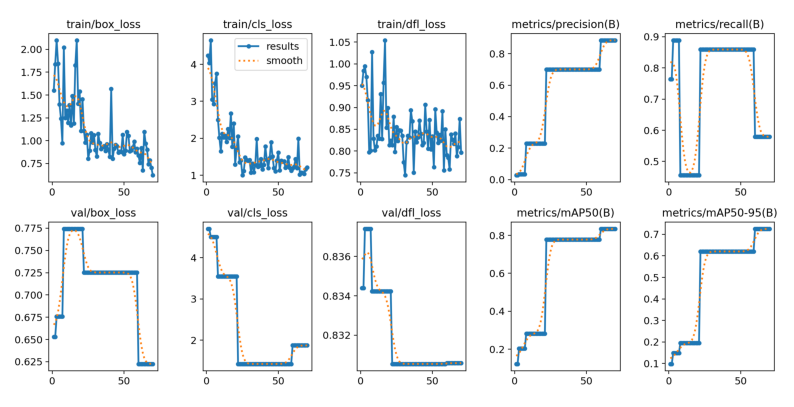

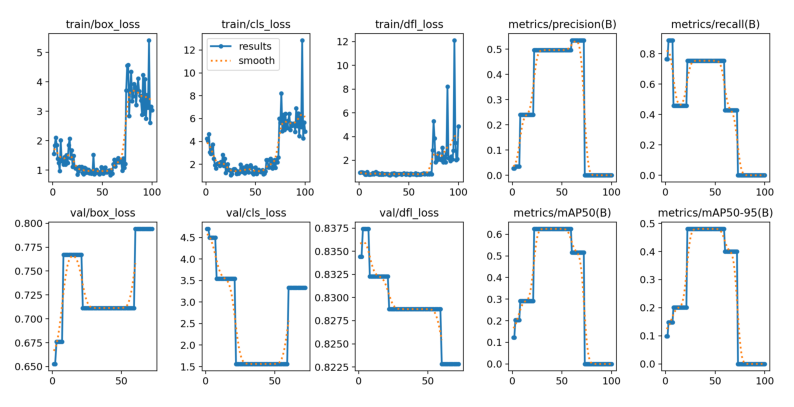

In [ ]:
# 70 epochs summary:
import matplotlib.pyplot as plt
import cv2 # Import cv2 to read the image
def show_image(image_path):
    # Read the image from the file path
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is not None:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.axis('off') # Hide axes for a cleaner image display
        plt.show()
    else:
        print(f"Error: Could not read image from {image_path}")

show_image('/content/runs/detect/train2/results.png') # 70 epochs
show_image('/content/runs/detect/train/results.png') # 100 epochs


image 1/1 /content/dots/test/images/dots_test.jpg: 512x640 18 dots, 4 others, 1421.4ms
Speed: 3.5ms preprocess, 1421.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


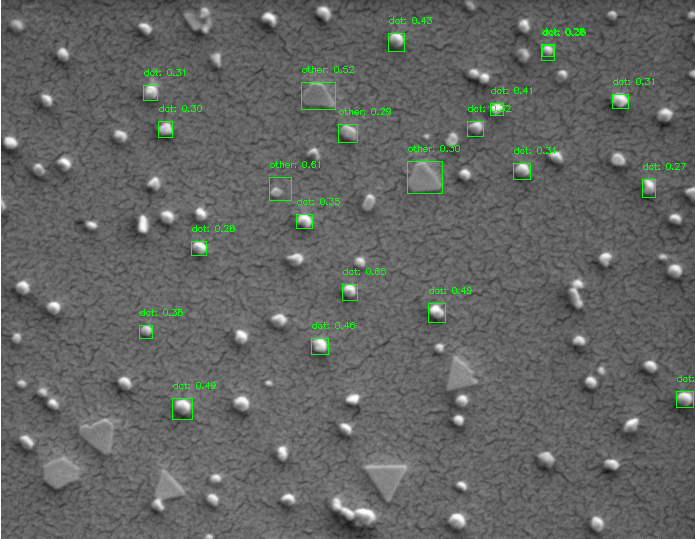

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

CLASS_MAP = {
    0: "dot",
    1: "other",
}
# Define the class map (reverse of your CLASS_MAP)
def draw_yolo_predictions_on_image(image_path, predictions, save_path=None):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return

    # Assuming 'predictions' contains results for a single image
    if len(predictions) == 0:
        print(f"No predictions found for image: {image_path}")
        if save_path:
            cv2.imwrite(save_path, image) # Save the original image if no predictions
        else:
            cv2_imshow(image)
        return

    # We expect the predictions for one image in the first element of the list
    results = predictions[0]

    if results.boxes is not None:
        for box in results.boxes:
            # Extract bounding box coordinates in pixel values
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Extract class ID and confidence
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])

            class_name = CLASS_MAP.get(class_id, str(class_id))
            label = f"{class_name}: {confidence:.2f}"

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1) # Green color, thickness 2
            # Put class label and confidence
            cv2.putText(image, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example Usage (assuming you have loaded your model and made predictions)
model = YOLO("/content/runs/detect/train2/weights/best.pt")
image_to_predict = '/content/dots/test/images/dots_test.jpg'
results = model.predict(image_to_predict) # Get results in memory
draw_yolo_predictions_on_image(image_to_predict, results)

In [ ]:
from ultralytics import YOLO

# Load the trained model
model = YOLO("/content/runs/detect/train2/weights/best.pt")

# Run the model in validation mode on the test dataset
# The 'split' argument should be set to 'test'
results = model.val(data='/content/dots/dots.yaml',split='test')

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11m summary (fused): 125 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2119.9±0.0 MB/s, size: 257.3 KB)


val: Scanning /content/dots/test/labels.cache... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


                   all          1        118        0.5      0.373      0.373      0.227
                   dot          1        111      0.903      0.459      0.654      0.385
                 other          1          7     0.0976      0.286     0.0925       0.07
Speed: 1.7ms preprocess, 1325.4ms inference, 0.0ms loss, 47.4ms postprocess per image
Results saved to runs/detect/val3


In [ ]:
precision = results.box.p  # Precision
recall = results.box.r    # Recall
# Calculate F1 score
# Add a small epsilon to the denominator to avoid division by zero if precision + recall is 0
epsilon = 1e-7
f1_score = 2 * (precision * recall) / (precision + recall + epsilon)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: [    0.90329    0.097552]
Recall: [    0.45946     0.28571]
F1 Score: [     0.6091     0.14544]


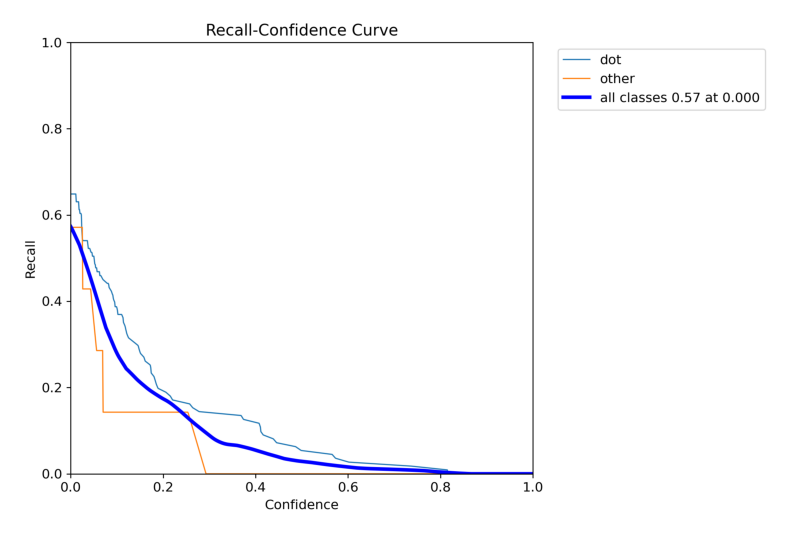

In [ ]:
show_image('/content/runs/detect/val2/R_curve.png')

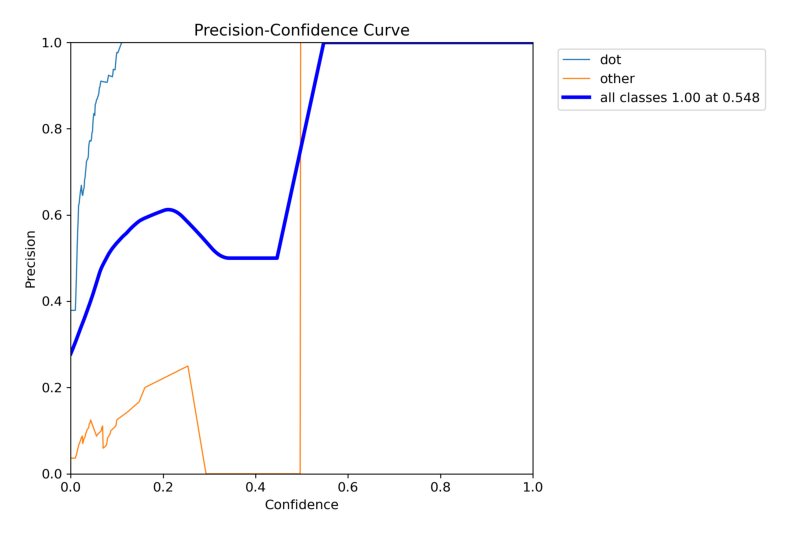

In [ ]:
show_image('/content/runs/detect/val2/P_curve.png')

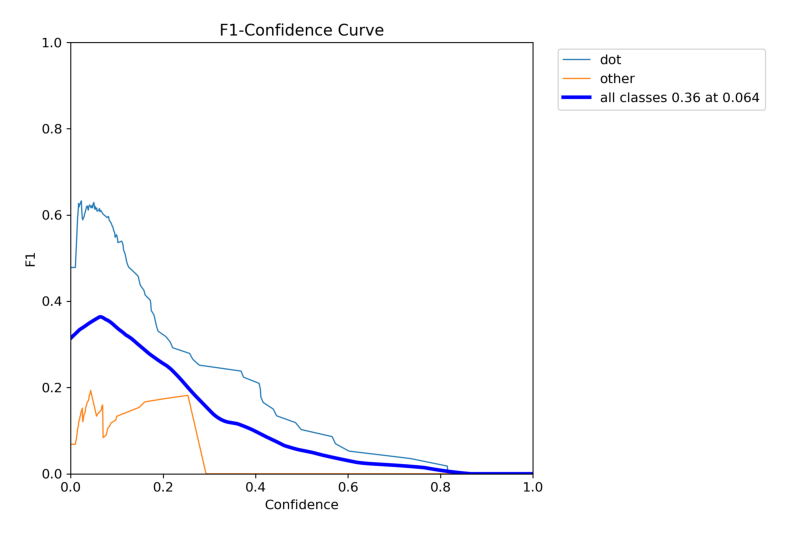

In [ ]:
show_image('/content/runs/detect/val2/F1_curve.png')

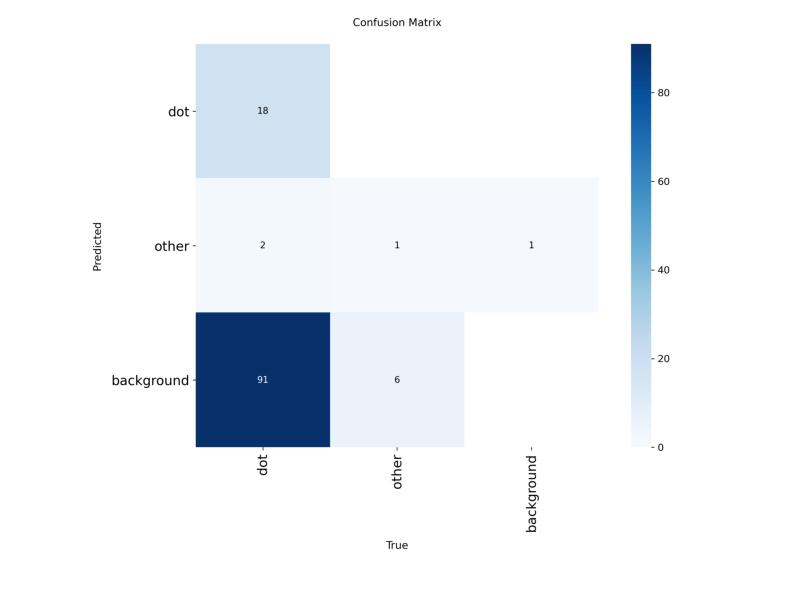

In [ ]:
show_image('/content/runs/detect/val2/confusion_matrix.png')